<b>Machine Learning I / Mini Lab Predictive Analysis</b>
<br><b>Authors:</b> Fabio Savorgnon, Tina Pai, Paritosh Rai, Ellen Lull
<br><b>Data set from:</b> https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

After our initial Exploratory Data Analysis (EDA) project, we needed to pick a model that would predict if a patient would have cardiovascular disease based on the variables available in our data.  These are:  gender, systolic blood pressure, diastolic blood pressure, age, height and weight (which we used to calculate Body Mass Index or BMI), a cholesterol level indicator, a glucose level indicator, and indicators to identify if a patient used alcohol, smoked or was active.    You can view the full descriptions of these data elements in our EDA document.
<br>  

During our EDA, we determined that the factors that had the highest level of correlation to cardiovascular disease were:   Blood pressure, BMI, Age, Cholesterol and Glucose.     However, we didn’t want to limit ourselves to only these.   So, we ran five combinations of these variables.  For each combination of variables, we ran both SVM and Logistical Regression models.  For each combination and method, we ran with scaled data and non-scaled data.   Our findings are documented below.


# Setup

In [235]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

dfin = pd.read_csv("cardio_train.csv", sep=";")



# Clean data

#### Weight and Height

In [236]:
# We address the weight with reasonable weight, the other values probably are a mistake
dfin = dfin[dfin["weight"] < 200]
dfin = dfin[dfin["weight"] > 55]

# We address the height, the other values probably are a mistake
dfin = dfin[dfin["height"] < 200]
dfin = dfin[dfin["height"] > 130]

#### BP Clean up

In [237]:
# Keeping only reasonable blood pressure measurements
dfin = dfin[dfin["ap_hi"] > 110]
dfin = dfin[dfin["ap_lo"] < 150]
dfin = dfin[dfin["ap_lo"] > 60]

#### Add BMI

In [238]:
# compute the body mass index based on weight and height
dfin['bmi'] = dfin['weight'] / (dfin['height']/100)**2

### Add bp

In [239]:
# bin blood pressure groups based on the api hi/ lo variables
dfin['bp'] = np.where((dfin.ap_hi < 120) & (dfin.ap_lo < 80), 1, 0)
dfin['bp'] = np.where((dfin.ap_hi >= 120) & (dfin.ap_hi < 130) & (dfin.ap_lo < 80), 2, dfin.bp)
dfin['bp'] = np.where((dfin.ap_hi >= 130) & (dfin.ap_hi < 140) | ((dfin.ap_lo >= 80) & (dfin.ap_lo < 90)), 3, dfin.bp)
dfin['bp'] = np.where((dfin.ap_hi >= 140) | (dfin.ap_lo >= 90), 4, dfin.bp)
dfin['bp'] = np.where((dfin.ap_hi > 180) | (dfin.ap_lo > 120), 5, dfin.bp)
dfin['bp'] = pd.cut(dfin.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


In [240]:
# Make a backup of the dataframe to use later in other models when we need a clean copy
df = dfin.copy(deep=True)
#df=dfin.copy(deep=False)

Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below

In [241]:

#show counts of people in each BMI group

df_grouped = df.groupby(by='bp')

df_grouped[['bp']].count()

,bp
bp,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,305


In [242]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,Hyper_Stage1


In [243]:
if 'cardio' in df:
    y = df['cardio'].values
    del df['cardio']
    X = df.values

In [244]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,37.729725,Hyper_Stage1


# Model Variable Selection Options

1. 'ap_hi' (highest co-relation)
2. 'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
3. 'bmi', 'age', ‘bp’, 'cholesterol'
4. ‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol'
5. 'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active', 'weight' (all variable)



some more explanation

## train test split

In [245]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

## SVM Baseline model (ap_hi only)

### Not Scaled

In [246]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73484996 0.73373353 0.73051278]


### Scaled

In [247]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73793992 0.73409683 0.73757284]


## SVM using BMI, age, ap_hi, ap_lo, cholesterol

### Not Scaled

In [248]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.64321623 0.6993939  0.47588858]


### Scaled

In [249]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.76639356 0.77038063 0.76869966]


In [250]:
dfin.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,Hyper_Stage1


# Hyperparameter Tuning

In [251]:
from sklearn.model_selection import GridSearchCV

### SVM

In [252]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',


In [253]:
clf.best_params_

{'classifier__alpha': 0.001,
 'classifier__loss': 'modified_huber',
 'classifier__penalty': 'l1'}

In [254]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


Best auc: 0.758408 using {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.758408 (0.008192) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.757774 (0.007686) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.753385 (0.013354) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.745677 (0.015692) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.748100 (0.007681) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.746677 (0.009164) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.732505 (0.001613) with: {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.738571 (0.0

## Probability Calibration

In [255]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.74936434 0.76637654 0.75203515]


## ROC

SVM Model ROC AUC=0.761


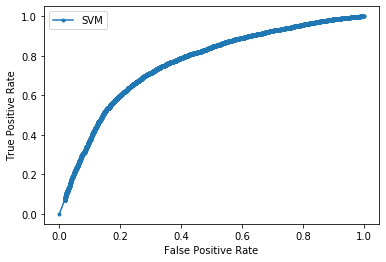

In [256]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Find probability threshold for best accuracy

In [257]:
svm_probs

array([0.59493307, 0.68979928, 0.31774004, ..., 0.76764536, 0.73853907,
       0.32758137])

In [258]:
alphas = np.arange(0, 1, .1)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))


alpha 0.000000 : accuracy=0.560
alpha 0.100000 : accuracy=0.561
alpha 0.200000 : accuracy=0.569
alpha 0.300000 : accuracy=0.616
alpha 0.400000 : accuracy=0.687
alpha 0.500000 : accuracy=0.704
alpha 0.600000 : accuracy=0.667
alpha 0.700000 : accuracy=0.603
alpha 0.800000 : accuracy=0.543
alpha 0.900000 : accuracy=0.499


### tune a little finer

In [259]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



alpha 0.400000 : accuracy=0.687
alpha 0.410000 : accuracy=0.692
alpha 0.420000 : accuracy=0.696
alpha 0.430000 : accuracy=0.701
alpha 0.440000 : accuracy=0.705
alpha 0.450000 : accuracy=0.706
alpha 0.460000 : accuracy=0.709
alpha 0.470000 : accuracy=0.709
alpha 0.480000 : accuracy=0.707
alpha 0.490000 : accuracy=0.707
alpha 0.500000 : accuracy=0.704
alpha 0.510000 : accuracy=0.701
alpha 0.520000 : accuracy=0.698
alpha 0.530000 : accuracy=0.694
alpha 0.540000 : accuracy=0.692
alpha 0.550000 : accuracy=0.688
alpha 0.560000 : accuracy=0.686
alpha 0.570000 : accuracy=0.681
alpha 0.580000 : accuracy=0.678
alpha 0.590000 : accuracy=0.671


### Logistic Regression

 There are multiple parameters that can help build a Logistic  Regression model listed below with the default value.  


*(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None])*



However, our team decided to focus on few critical in tuning process like C, solver and penalty. 



Hyperparameters sets the algorithm that can be adjusted to optimize performance, these are the knobs to generate optimal outcome. These Hyperparameters in machine learning model help define your model architecture. Leveraging grid search optimal automated exploration is launched to find the optimal parameter value to extract best model architecture. 

The project Grid search approach was used to tune the parameters of the model. Grid search is an approach to hyperparameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. However, grid search suffers from the curse of dimensionality: the number of times required to evaluate the model during hyperparameter optimization grows exponentially in the number of parameters. 

The other popular method is Random Search. It is performed by evaluating n uniformly random points in the hyperparameter space and select the one producing the best performance. The drawback of random search is unnecessarily high variance. The method is, after all, entirely random, and uses no intelligence in selecting which points to try. You are relying on luck to get good results.

In the model building excises Grid Search was used and to overcome the curse of dimensionality hyper parameter list was highly evaluated and one making maxim impact were chosen. The model tuning process three parameters were considered, C, penalty and Solver. 

<b>C:</b> This control the complexity and simplicity of model. However, complexity can lead to over fitting vs. simplicity will lead to under fitting. Small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C the power of regularization is decrease which impels the model is allowed to increase it's complexity, and therefore, overfit the data. 

<b>Penalty:</b> This project uses two penalties. Li and L2. The Penalty is used to specify the penalization method of the coefficients of noncontributing or less contributing variables.
Lasso (L1) performs feature selection by shrinking the less important feature’s coefficient to zero.
Ridge (L2) all variables are included in the model, though some are shrunk (but not to zero like L1 Penalty. Less computationally intensive than lasso.
Both penalty values restrict solver choices. It is critical to choose the right combination of Penalty.



<b>Solver:</b> Are the algorithm used in Logistic Regression to predict the outcome. Default value is lbfgs. other possible values (to list few) are, liblinear, sag and saga.
liblinear − It is a good choice for small datasets. It also handles L1 penalty. For multiclass problems, it is limited to one-versus-rest schemes.
lbfgs − For multiclass problems, it handles multinomial loss. It also handles only L2 penalty.
saga − It is a good choice for large datasets. For multiclass problems, it also handles multinomial loss. Along with L1 penalty, it also supports ‘elasticnet’ penalty.
sag − It is also used for large datasets. For multiclass problems, it also handles multinomial loss.



<b>Ref:</b> 
https://sigopt.com/blog/common-problems-in-hyperparameter-optimization

https://towardsdatascience.com/hyper-parameter-tuning-and-model-selection-like-a-movie-star-a884b8ee8d





In [260]:
dfin.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,Hyper_Stage1


In [261]:
#data setup
df1 = dfin
#df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
 
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,Hyper_Stage1


In [262]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,Hyper_Stage1


## Description of Logistical Regression Options:

Description of Variable Combinations for Logistical Regresson models: 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest correlation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [263]:
df=dfin
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,Hyper_Stage1


In [276]:
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','gluc','smoke','alco','active','cardio','bp'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

KeyError: 'cardio'

In [265]:
df.head()

,age,ap_hi,ap_lo,cholesterol,bmi
1,20228,140,90,3,34.927679
2,18857,130,70,3,23.507805
3,17623,150,100,1,28.710479
5,21914,120,80,2,29.384676
6,22113,130,80,3,37.729725


In [266]:
dfin.head()

,age,ap_hi,ap_lo,cholesterol,bmi
1,20228,140,90,3,34.927679
2,18857,130,70,3,23.507805
3,17623,150,100,1,28.710479
5,21914,120,80,2,29.384676
6,22113,130,80,3,37.729725


### Option 1 model

In [267]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [268]:
#make a grid search for logistic regression


param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

{'mean_fit_time': array([0.59906395, 0.70145639, 0.56948709, 0.75632087, 0.62601296,
        0.14195355, 0.14261858, 0.13829684, 0.14328361, 0.14494514]),
 'std_fit_time': array([0.18142376, 0.21545753, 0.10649503, 0.09266549, 0.14858796,
        0.03170964, 0.03467279, 0.04069419, 0.0343289 , 0.03341985]),
 'mean_score_time': array([0.00332443, 0.0036571 , 0.00331378, 0.0033141 , 0.0036358 ,
        0.00398938, 0.00332427, 0.0039893 , 0.00299152, 0.00365734]),
 'std_score_time': array([4.70077860e-04, 4.70358829e-04, 4.78115316e-04, 4.77860875e-04,
        4.78027064e-04, 1.12391596e-07, 4.70190252e-04, 1.12391596e-07,
        2.24783192e-07, 4.70527668e-04]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [269]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.768815 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.768556 (0.004150) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.768671 (0.003977) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.768815 (0.003843) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.768047 (0.003971) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.768655 (0.003401) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.635748 (0.007408) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.635709 (0.007428) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.635700 (0.007432) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.635700 (0.007432) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.635701 (0.007432) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [271]:

from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=1000, class_weight=None, solver='liblinear' ) # get object


In [272]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7629193833918267
confusion matrix
 [[3111 1550]
 [1581 4403]]
====Iteration 1  ====
auc 0.7560733341937407
confusion matrix
 [[3164 1535]
 [1584 4362]]
====Iteration 2  ====
auc 0.7638123978593047
confusion matrix
 [[3082 1660]
 [1430 4473]]


#### train test split

In [273]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

#### Logistic Regression Scaled

In [274]:
dfin.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,Hyper_Stage1


In [275]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Hyper Parameter Tuning

In [40]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

{'mean_fit_time': array([0.09507465, 1.04771495, 0.1003983 , 0.86069775, 0.06682094,
        0.83876864, 0.06615575, 0.85372996, 0.06150349, 0.86403624,
        0.04587889, 0.79057765, 0.82132093, 0.06017232, 0.72605729,
        0.73571245, 0.05718064, 0.69549441, 0.71278683, 0.04820498,
        0.66089948, 0.72472835, 0.06150262, 0.70496281, 0.68151085]),
 'std_fit_time': array([0.01074711, 0.06242498, 0.01821477, 0.05924451, 0.00354981,
        0.05495627, 0.00463013, 0.08746861, 0.00756679, 0.05621345,
        0.00215523, 0.0197143 , 0.03769932, 0.00261764, 0.02850095,
        0.00755299, 0.00950815, 0.06374556, 0.01016355, 0.00497352,
        0.03206422, 0.05017228, 0.00384877, 0.02075222, 0.00188065]),
 'mean_score_time': array([0.00664926, 0.00498637, 0.00631642, 0.00398898, 0.00432189,
        0.00397746, 0.00432245, 0.00397642, 0.00433143, 0.00364383,
        0.0039885 , 0.0046277 , 0.00465345, 0.00531912, 0.0039893 ,
        0.00397619, 0.00432165, 0.00363533, 0.00396395, 0.00

In [41]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.764275 using {'classifier__C': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
0.762845 (0.007816) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.753229 (0.007916) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.764132 (0.007381) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.753949 (0.007745) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.764253 (0.007343) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.753985 (0.007800) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.764271 (0.007333) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.753989 (0.007794) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.764247 (0.00734

In [42]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7523105462200697
[0.70023485 0.69384688 0.69694692]


C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [43]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


====Iteration 0  ====
auc 0.7444468680686455
confusion matrix
 [[3091 1621]
 [1633 4300]]


C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


====Iteration 1  ====
auc 0.7473724736212846
confusion matrix
 [[3076 1582]
 [1661 4326]]
====Iteration 2  ====
auc 0.7510826707593753
confusion matrix
 [[3131 1515]
 [1665 4334]]


C:\Users\Ellen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [44]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

#### precision recall curve

In [ ]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Option 3 model

In [ ]:
#data setup
import pandas as pd
df1 = pd.read_csv("cardio_train.csv", sep=";")
#df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

In [ ]:
df_clean.head()

### Option 3
Following are combo I selected based on high correlation and removing

'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
'ap_hi' (highest co-relation)
'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)

In [ ]:
df=df_clean
df1
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','cardio','bp'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
print(cv_object)

In [ ]:
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

#### train test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

In [ ]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#### Logistic Regression Scaled

In [ ]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Hyper Parameter Tuning

In [ ]:
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

#### precision recall curve

In [ ]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

##### The following is the summary of Analysis that was run on Logistic Regression and SVM with Five options in unscaled and scaled options.

The chart below shows the comparison of all models we ran on AUC score.   We are showing the results of the more significant models in the main body of this notebook, and have included the models of less interest in the Appendix.

We compared all models both with and without scaling the data.  

The highest performing model for Logistic Regression, per AUC, was Option 3, which included all variables.   A very close score was obtained for Option 1, which included: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.   Since these Option 1 variables were our most significant variables per our Exploratory Data Analysis, we chose Option 1 as our preferred model.  For these Logistical Regression models, scaling the data did not seem to help.

The highest performing model for SVM was option 1 with the variables described above.   In this case, scaling the data did make a difference.

Our primary model is Logistic Regression, unscaled data with the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

Our backup/ secondary model is SVM with scaled data and the following attributes: Body Mass Index, Systolic Blood Pressure, Diastolic Blood pressure, Cholesterol and Age.

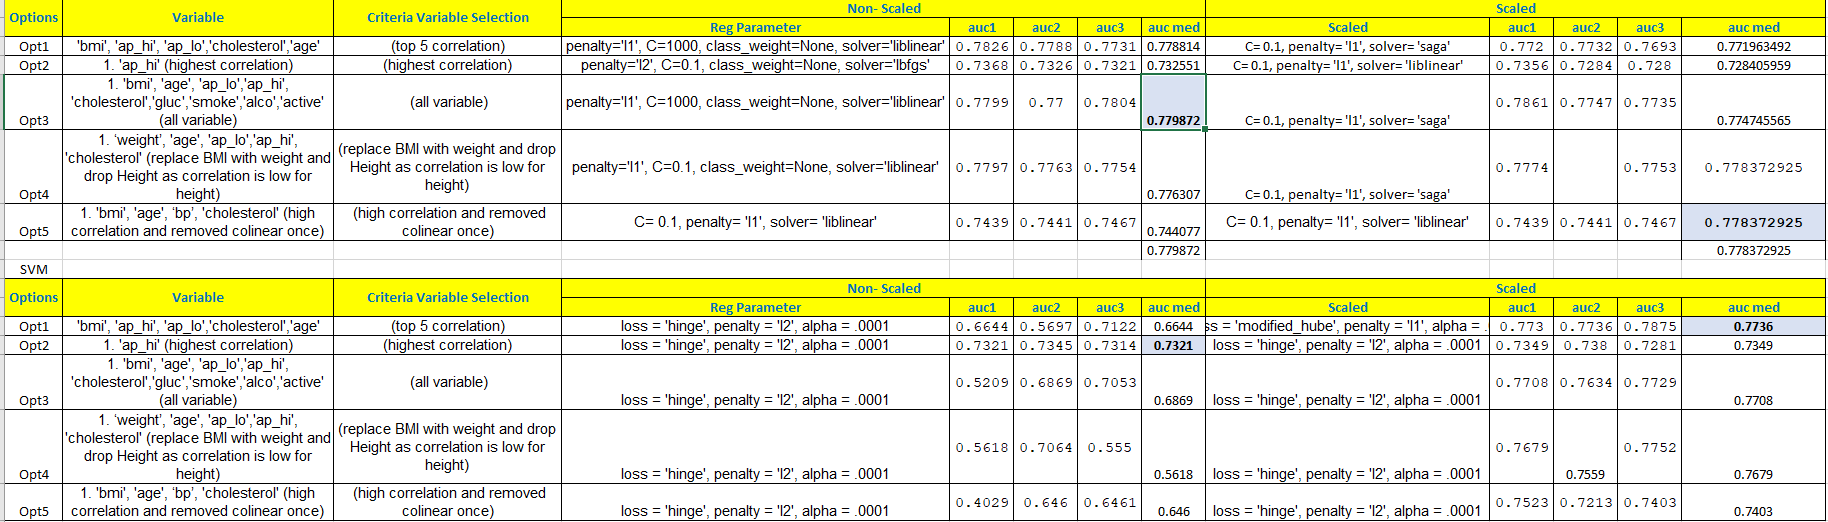

# SVM

Our favorite SVM model is Option 1 Scaled

Confusion matrix / classification report  - Ellen

precision, recall, f1, accuracy - Ellen

explain the hyperparameters - Tina

### Interpretation

Make SVC from subsampled set - Tina

Ellen

# Logistic regression

Our favorite Logistic model is Option 1 Unscaled

Confusion matrix / classification report 

precision, recall, f1, accuracy

explain the hyperparameters - Paritosh, Fabio

### Weights Interpretation

Fabio

# Advantages and Disadvantages

Our favorite model overall is the Logistic regression option 1 unscaled.

Is one better about training time?

Is one better from accuracy?

# Appendix

## Decision Tree Model

In [ ]:
df=df_clean
df.head()


In [ ]:
from sklearn.model_selection import train_test_split
X = df[['bmi', 'ap_hi', 'ap_lo','cholesterol','age']]
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [ ]:
"""#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)
"""

#### Training a Decision Tree Model
Let's start by training a single decision tree first!

** Import DecisionTreeClassifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree.fit(X_train,y_train)

#### Predictions and Evaluation of Decision Tree

Create predictions from the test set and create a classification report and a confusion matrix

In [ ]:
predictions = dtree.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:

from sklearn import metrics as mt
auc = mt.roc_auc_score(y_test,predictions)
print("auc", auc )

### Training the Random Forest model
Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=600)

In [ ]:
rfc.fit(X_train,y_train)

### Predictions and Evaluation
Let's predict off the y_test values and evaluate our model.

** Predict the class of not.fully.paid for the X_test data.**

In [ ]:
predictions = rfc.predict(X_test)

Now create a classification report from the results.

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

## The following Logistical Regression Models were rejected, but they were not far in accuracy and AUC scores from the preferred model.

## Description of Logistical Regression Options:

Description of Variable Combinations for Logistical Regresson models: 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest correlation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


### Option 1 model is shown earlier in this document as it is the model we have chosen

### Option 2   AP_HI variable only (systolic blood pressure).  With unscaled data

In [ ]:
df=df_clean
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','age','gender','height','weight','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','bmi','bp'], axis =1, inplace = True) # get rid of the class label
df.head(5)
X = df.values # Option1
#X

## Option 2 model

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
#  {'C': [.1, 1, 10, 100, 1000],
 #  'penalty': ['l1'],
  # 'solver': ['liblinear', 'saga']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = LogisticRegression(max_iter=4000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='lbfgs' ) # get object




In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

### train test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [ ]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### precision recall curve

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()




### Option 3

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [ ]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

## Data Cleanup

### Weight and Height

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [ ]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

## Data Cleanup

### Weight and Height

In [ ]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [ ]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [ ]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [ ]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [ ]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

In [ ]:
df1.head(5)

## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [ ]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','cardio','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 3 model

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_


In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object




In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

### train test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [ ]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [ ]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### precision recall curve

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()



### Option 4

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [ ]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

## Data Cleanup

### Weight and Height

In [ ]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [ ]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [ ]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [ ]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [ ]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

In [ ]:
df1.head(5)

## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [ ]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','gluc','smoke','alco','active','cardio','bmi','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 4 model

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_






In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object




In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

### train test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [ ]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [ ]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### precision recall curve

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()




### Option 5

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

In [ ]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

## Data Cleanup

### Weight and Height

In [ ]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

### BP Clean up

In [ ]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [ ]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp 

In [ ]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [ ]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

In [ ]:
df1.head(5)

## Options

Following are combo I selected based on high correlation and removing 
1.	'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
2.	'ap_hi' (highest co-relation)
3.	'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
4.	‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
5.	'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)


In [ ]:
df=df1
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

## Option 5 model

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

### Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
LogisticRegression()
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object




In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

### train test split

In [ ]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

# Scaling

### Logistic Regression Scaled

In [ ]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


### Hyper Parameter Tuning 

In [ ]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



In [ ]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from sklearn.metrics import roc_auc_score

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)


In [ ]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

In [ ]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

In [ ]:
model=clf.best_estimator_.fit(X,y)

In [ ]:
model.named_steps["classifier"].coef_

### precision recall curve

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()